# <img src="https://img.icons8.com/dusk/64/000000/artificial-intelligence.png" style="height:50px;display:inline"> EE 046202 - Technion - Unsupervised Learning & Data Analysis
---

## Computer Assignment 2 - Variational Autoencoders & Clustering
---
### <a style='color:red'> Due Date: 26.01.2021 </a>


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* Variational Autoencoders (VAEs)
    * $\beta$-VAE
    * Conditional VAE (CVAE)
    * BONUS: Generating Pokemons
* Clustering
    * Spectral Clustering for Image Segmentation
    * Spectral Clustering vs. K-Means for Image Segmentation

#### Use as many cells as you need
#### אפשר גם לכתוב בעברית, אבל עדיף באנגלית

* Code Tasks are denoted with: <img src="https://img.icons8.com/color/48/000000/code.png">
* Questions (which you need to answer in a Markdown cell) are denoted with: <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png">

### <img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline"> Students Information
---
* Fill in

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Yair Nahum| nahum.yair@campus.technion.ac.il| 034462796|
|David Regev| regev.david@campus.technion.ac.il| 204813323|



### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
* Maximal garde: **100** (even with the bonus, the grade will not be above 100).
    * Example: if you got 5 points bonus, but you were right in all sections, your grade will still be 100 (and not 105).
    * Example: if you got 5 points bonus, and 6 points were deducted for wrong answers, your grade will be 99.
* Submission only in **pairs**. 
    * Please make sure you have registered your group in Moodle (there is a group creation component on the Moodle where you need to create your group and assign members).
* **BONUS**:
    * 5 points - completing the Pokemon task with *fully-connected* layers (black & white version)
    * 10 points - completing the Pokemon task with *convolutional* layers (RGB version)
* **No handwritten submissions.** You can choose whether to answer in a Markdown cell in this notebook or attach a PDF with your answers.
* <a style='color:red'> SAVE THE NOTEBOOKS WITH THE OUTPUT, CODE CELLS THAT WERE NOT RUN WILL NOT GET ANY POINTS! </a>
* What you have to submit:
    * If you have answered the questions in the notebook, you should submit this file only, with the name: `ee046202_wet2_id1_id2.ipynb`.
    * If you answered the questionss in a different file you should submit a `.zip` file with the name `ee046202_wet2_id1_id2.zip` with content:
        * `ee046202_wet2_id1_id2.ipynb` - the code tasks
        * `ee046202_wet2_id1_id2.pdf` - answers to questions.
    * No other file-types (`.py`, `.docx`...) will be accepted.
* Submission on the course website (Moodle).
* **Latex in Colab** - in some cases, Latex equations may no be rendered. To avoid this, make sure to not use *bullets* in your answers ("* some text here with Latex equations" -> "some text here with Latex equations").

### <img src="https://img.icons8.com/clouds/96/000000/keyboard.png" style="height:50px;display:inline"> Keyboard Shortcuts
---
* Run current cell: **Ctrl + Enter**
* Run current cell and move to the next: **Shift + Enter**
* Show lines in a code cell: **Esc + L**
* View function documentation: **Shift + Tab** inside the parenthesis or `help(name_of_module)`
* New cell below: **Esc + B**
* Delete cell: **Esc + D, D** (two D's)

### <img src="https://img.icons8.com/cute-clipart/64/000000/info.png" style="height:50px;display:inline"> Tip
---
If you find it more convenient, you can copy the section to a new cell, and answer the question or rite the code just right below it. For example:

#### Question 0
1. What is the best course in the Technion?
2. Why does no one pick Bulbasaur as first pokemon?
3. Why is there no superhero named Catman?

#### Answers - Q0

#### Q0 - Section 1
* Q: What is the best course in the Technion?

In [1]:
print("ANAM!")

ANAM!


#### Q0 - Section 2
* Q: Why does no one pick Bulbasaur as first pokemon?

It is really a riddle....

#### Q0 - Section 3
* Q: Why is there no superhero named Catman?

I got nothing.

### <img src="https://img.icons8.com/cotton/64/000000/grand-master-key.png" style="height:50px;display:inline"> Part 1 - Variational Autoencoders - Prologue
---
In this section of the exercise we will analyze the VAE and introduce an enhacement called $\beta$-VAE and also a variation of VAE that allows us some control over the latent space using conditional probability - Conditional Variational Autoencoder.

For this part, you are provided the original implementation of the VAE from the tutorial. You will have to modify it throughout the tasks (yes yes, you can copy-paste from the original implementation).
* **Note** - for better results you should tune the model!
    * You can add layers / hidden units / different activations (ReLU, TanH, LeakyReLU, Sigmoid...)
    * You can choose a different optimizer than Adam (SGD, RMSProp...), tune the learning rate...
    * You can change the reconstruction loss (BCE, MSE, L1...)
    * Other hyper-parameters like the batch-size, number of epochs and etc...

We recommend running this part on Google Colab or on a GPU (if you have an access to one). Note that running on a GPU will lead to about x2 speedup in training. 

In [2]:
# imports for the exrcise - part 1
# you can add more if you wish (but it is not really needed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 1 - $\beta$-VAE
---
In the standard VAE an isotropic Gaussian ($p(z) \sim \mathcal{N}(0, I)$) is typically assumed as the prior distribution for z. Note that under this distribution the components of z are independent (e.g. disentangled - a disentangled representation can be defined as one where single latent units are sensitive to changes in single generative factors, while being relatively invariant to changes in other factors) which is exactly the property we would like our approximate posterior distribution (e.g. $q(z|x)$) to have. Thus, to encourage independence we increase the KL-divergence term in the ELBO by a factor of $\beta$: $$ \mathcal{L}_{\beta-VAE} = -\mathbb{E}_{q_{\phi(z|x)}}[p_{\theta}(x|z)] + \beta \cdot D_{KL}[q_{\theta}(z|x) || p(z)]  $$
   * Training is performed exactly the same as for the standard VAE.
   * When $\beta=1$, it is same as VAE.
   * When $\beta>1$, it applies a stronger constraint on the latent bottleneck and limits the representation capacity of $z$. 
       * For some conditionally independent generative factors, keeping them disentangled is the most efficient representation.
   * When $0<\beta<1$, it can be interpreted as optimizing an approximate log marginal likelihood bound under an alternative prior, regularized to prevent degeneracy (of the KL-divergence).
   
The tasks:
1. Modify the loss function to support $\beta$-VAE. The function should return the reconstruction loss, the kl-divergence (**without the multiplication by $\beta$**) and and the total loss.
    * The signature of the function should be: `beta_loss_function(recon_x, x, mu, logvar, loss_type='bce', beta=1)`
    * The reconstruction loss, the kl-divergence and and the total loss should be normalzied by the batch size.
    * The returned reconstruction loss and kl-divergence should be converted to numpy: `kl_d.data.cpu().numpy()` (but only them, not the total loss)
2. Load the MNIST dataset, as in the tutorial, and create a train loader.
3. For $\beta=[0.05, 0.5, 1, 5]$, train a $\beta$-VAE for 50 epochs and keep track of:
    * The average reconstruction loss in each epoch
    * The average KL-divergence in each epoch
    * A checkpoint of the network in the format: `beta_(value of beta)_vae_50_epochs.pth` (there is an example in the tutorial)
    * This may take a while, so go grab a coffee in the meantime :)
4. For $\beta=[0.05, 0.5, 1, 5]$, plot the KL-divergence and reconstruction error vs. epochs.
5. For $\beta=[0.05, 0.5, 1, 5]$, generate 5 samples from the VAE and plot them (`imshow`...). Run this a couple of times to get an impression of the samples for each $\beta$.


* Notes:
    * Be organized - separate to different code cells if it keeps you organized.
    * Make sure to properly define the hyper-parameters (see tutorial), and define the `device` automatically. Don't forget to send all the models and tensors to the device. We will run your code on a GPU.
    * If you are not satisfied with the results, and you have time, you can try and increase the number of epochs to 100, and see what happens.

In [3]:
# your code here - you can use as many cells as you need

# reparametrization trick
def reparameterize(mu, logvar, device=torch.device("cpu")):
  """
  This function applies the reparameterization trick:
  z = mu(X) + sigma(X)^0.5 * epsilon, where epsilon ~ N(0,I)
  :param mu: mean of x
  :param logvar: log variance of x
  :param device: device to perform calculations on
  :return z: the sampled latent variable
  """
  std = torch.exp(0.5 * logvar)
  eps = torch.randn_like(std).to(device)
  return mu + eps * std


# encoder - Q(z|X)
class VaeEncoder(torch.nn.Module):
  """
  This class builds the encoder for the VAE
  :param x_dim: input dimensions
  :param hidden_size: hidden layer size
  :param z_dim: latent dimensions
  :param device: cpu or gpu
  """

  def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10, device=torch.device("cpu")):
    super(VaeEncoder, self).__init__()
    self.x_dim = x_dim
    self.hidden_size = hidden_size
    self.z_dim = z_dim
    self.device = device
    
    self.features = nn.Sequential(nn.Linear(x_dim, self.hidden_size),
                                  nn.ReLU())
    
    self.fc1 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output mu
    self.fc2 = nn.Linear(self.hidden_size, self.z_dim, bias=True)  # fully-connected to output logvar


  def bottleneck(self, h):
    """
    This function takes features from the encoder and outputs mu, log-var and a latent space vector z
    :param h: features from the encoder
    :return: z, mu, log-variance
    """
    mu, logvar = self.fc1(h), self.fc2(h)
    # use the reparametrization trick as torch.normal(mu, logvar.exp()) is not differentiable
    z = reparameterize(mu, logvar, device=self.device)
    return z, mu, logvar

  def forward(self, x):
    """
    This is the function called when doing the forward pass:
    z, mu, logvar = VaeEncoder(X)
    """
    h = self.features(x)
    z, mu, logvar = self.bottleneck(h)
    return z, mu, logvar

    
class VaeDecoder(torch.nn.Module):
  """
  This class builds the decoder for the VAE
  :param x_dim: input dimensions
  :param hidden_size: hidden layer size
  :param z_dim: latent dimensions
  """

  def __init__(self, x_dim=28*28, hidden_size=256, z_dim=10):
    super(VaeDecoder, self).__init__()
    self.x_dim = x_dim
    self.hidden_size = hidden_size
    self.z_dim = z_dim
    
    self.decoder = nn.Sequential(nn.Linear(self.z_dim, self.hidden_size),
                                  nn.ReLU(),
                                  nn.Linear(self.hidden_size, self.x_dim),
                                  nn.Sigmoid())
    # why we use sigmoid? becaue the pixel values of images are in [0,1] and sigmoid(x) does just that!
    # if you don't work with images, you don't have to use that.


  def forward(self, x):
    """
    This is the function called when doing the forward pass:
    x_reconstruction = VaeDecoder(z)
    """
    x = self.decoder(x)
    return x
    

class Vae(torch.nn.Module):
  def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu")):
    super(Vae, self).__init__()
    self.device = device
    self.x_dim = x_dim
    self.z_dim = z_dim

    self.encoder = VaeEncoder(x_dim, hidden_size, z_dim=z_dim, device=device)
    self.decoder = VaeDecoder(x_dim, hidden_size, z_dim=z_dim)

  def encode(self, x):
    z, mu, logvar = self.encoder(x)
    return z, mu, logvar

  def decode(self, z):
    x = self.decoder(z)
    return x

  def sample(self, num_samples=1):
    """
    This functions generates new data by sampling random variables and decoding them.
    Vae.sample() actually generatess new data!
    Sample z ~ N(0,1)
    """
    z = torch.randn(num_samples, self.z_dim).to(self.device)
    return self.decode(z)

  def forward(self, x):
    """
    This is the function called when doing the forward pass:
    return x_recon, mu, logvar, z = Vae(X)
    """
    z, mu, logvar = self.encode(x)
    x_recon = self.decode(z)
    return x_recon, mu, logvar, z



In [4]:
#1 

def beta_loss_function(recon_x, x, mu, logvar, loss_type='bce', beta=1):
  """
  This function calculates the loss of the VAE.
  loss = reconstruction_loss - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  :param recon_x: the reconstruction from the decoder
  :param x: the original input
  :param mu: the mean given X, from the encoder
  :param logvar: the log-variance given X, from the encoder
  :param loss_type: type of loss function - 'mse', 'l1', 'bce'
  :return: VAE loss
  """
  if loss_type == 'mse':
    recon_error = F.mse_loss(recon_x, x, reduction='sum')
  elif loss_type == 'l1':
    recon_error = F.l1_loss(recon_x, x, reduction='sum')
  elif loss_type == 'bce':
    recon_error = F.binary_cross_entropy(recon_x, x, reduction='sum')
  else:
    raise NotImplementedError

  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # https://arxiv.org/abs/1312.6114
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  batch_size = x.size(0)
  kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
  kl /= batch_size
  recon_error /= batch_size 
  total_loss = (recon_error + beta*kl) 
  kl = kl.data.cpu().numpy()
  recon_error = recon_error.data.cpu().numpy()
  return recon_error, kl, total_loss

In [5]:
#2

# define hyper-parameters
BATCH_SIZE = 128  # usually 32/64/128/256
LEARNING_RATE = 1e-3  # for the gradient optimizer
NUM_EPOCHS = 150  # how many epochs to run?
HIDDEN_SIZE = 256  # size of the hidden layers in the networks
X_DIM = 28 * 28  # size of the input dimension
Z_DIM = 10  # size of the latent dimension
BETA_LIST = [0.05, 0.5, 1, 5]

# let's load the dataset and see some examples

# in order to create batches of the data, we create a Dataset and a DataLoader, which takes care of:
# 1. pre-processing the images to tensors with values in [0,1]
# 2. shuffling the data, so we add randomness as learned in ML
# 3. if the data size is not divisible by the batch size, we can drop the last batch 
# (so the batches are always of the same size)

# define pre-procesing transformation to use
transform = torchvision.transforms.ToTensor()

train_data = torchvision.datasets.MNIST('./datasets/', train=True, transform=transform,
                                        target_transform=None, download=True)
test_data = torchvision.datasets.MNIST('./datasets/', train=False, transform=transform,
                                       target_transform=None, download=True)


# load the data
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)



Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
#3 


# training

# check if there is gpu avilable, if there is, use it
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("running calculations on: ", device)


running calculations on:  cuda:0


In [7]:
# here we go

beta_loss_table = []
beta_recon_error_table = []
beta_kl_table = []

for beta_value in BETA_LIST:

  print("Beta {:.2f}".format(beta_value))
  
  # create our model and send it to the device (cpu/gpu)
  vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
  
  # optimizer 
  vae_optim = torch.optim.Adam(params=vae.parameters(), lr=LEARNING_RATE)
  
  # save the loss data from each epoch, we might want to plot it later
  epoch_train_loss_list = []
  epoch_train_recon_error_list = []
  epoch_train_kl_list = []

  for epoch in range(NUM_EPOCHS):

    epoch_start_time = time.time()
    batch_recon_error_list = []
    batch_kl_list = []
    batch_losses = []
    
    for batch_i, batch in enumerate(dataloader):
      
      # forward pass
      x = batch[0].to(device).view(-1, X_DIM)  # just the images
      x_recon, mu, logvar, z = vae(x)
      
      # calculate the loss
      recon_error, kl, loss = beta_loss_function(x_recon, x, mu, logvar, loss_type='bce', beta=beta_value)
      batch_recon_error_list.append(recon_error)
      batch_kl_list.append(kl)

      # optimization (same 3 steps everytime)
      vae_optim.zero_grad()
      loss.backward()
      vae_optim.step()
      
      # save loss
      batch_losses.append(loss.data.cpu().item())

    epoch_train_loss_list.append(np.mean(batch_losses))
    epoch_train_recon_error_list.append(np.mean(batch_recon_error_list))
    epoch_train_kl_list.append(np.mean(batch_kl_list))
    
    if epoch % 5 == 0:
      print("\tepoch: {} training loss: {:.5f} epoch time: {:.3f} sec".format(epoch, epoch_train_loss_list[-1],
                                                                              time.time() - epoch_start_time))

  beta_loss_table.append(epoch_train_loss_list)    
  beta_recon_error_table.append(epoch_train_recon_error_list)
  beta_kl_table.append(epoch_train_kl_list)

  # saving our model (so we don't have to train it again...)
  # this is one of the greatest things in pytorch - saving and loading models
  # save
  fname = "./beta_" + str(beta_value) + "_vae_" + str(NUM_EPOCHS) + "_epochs.pth"
  torch.save(vae.state_dict(), fname)
  print("saved checkpoint @", fname)


Beta 0.05
	epoch: 0 training loss: 151.94348 epoch time: 6.240 sec
	epoch: 5 training loss: 94.09594 epoch time: 6.066 sec
	epoch: 10 training loss: 89.99008 epoch time: 6.006 sec
	epoch: 15 training loss: 87.96859 epoch time: 5.901 sec
	epoch: 20 training loss: 86.70358 epoch time: 5.767 sec
	epoch: 25 training loss: 85.79677 epoch time: 5.837 sec
	epoch: 30 training loss: 85.11819 epoch time: 5.775 sec
	epoch: 35 training loss: 84.59992 epoch time: 5.852 sec
	epoch: 40 training loss: 84.17401 epoch time: 5.639 sec
	epoch: 45 training loss: 83.79158 epoch time: 5.902 sec
	epoch: 50 training loss: 83.51758 epoch time: 6.118 sec
	epoch: 55 training loss: 83.24384 epoch time: 5.884 sec
	epoch: 60 training loss: 83.02918 epoch time: 5.898 sec
	epoch: 65 training loss: 82.82830 epoch time: 5.868 sec
	epoch: 70 training loss: 82.65212 epoch time: 5.965 sec
	epoch: 75 training loss: 82.50019 epoch time: 5.966 sec
	epoch: 80 training loss: 82.36685 epoch time: 5.918 sec
	epoch: 85 training l

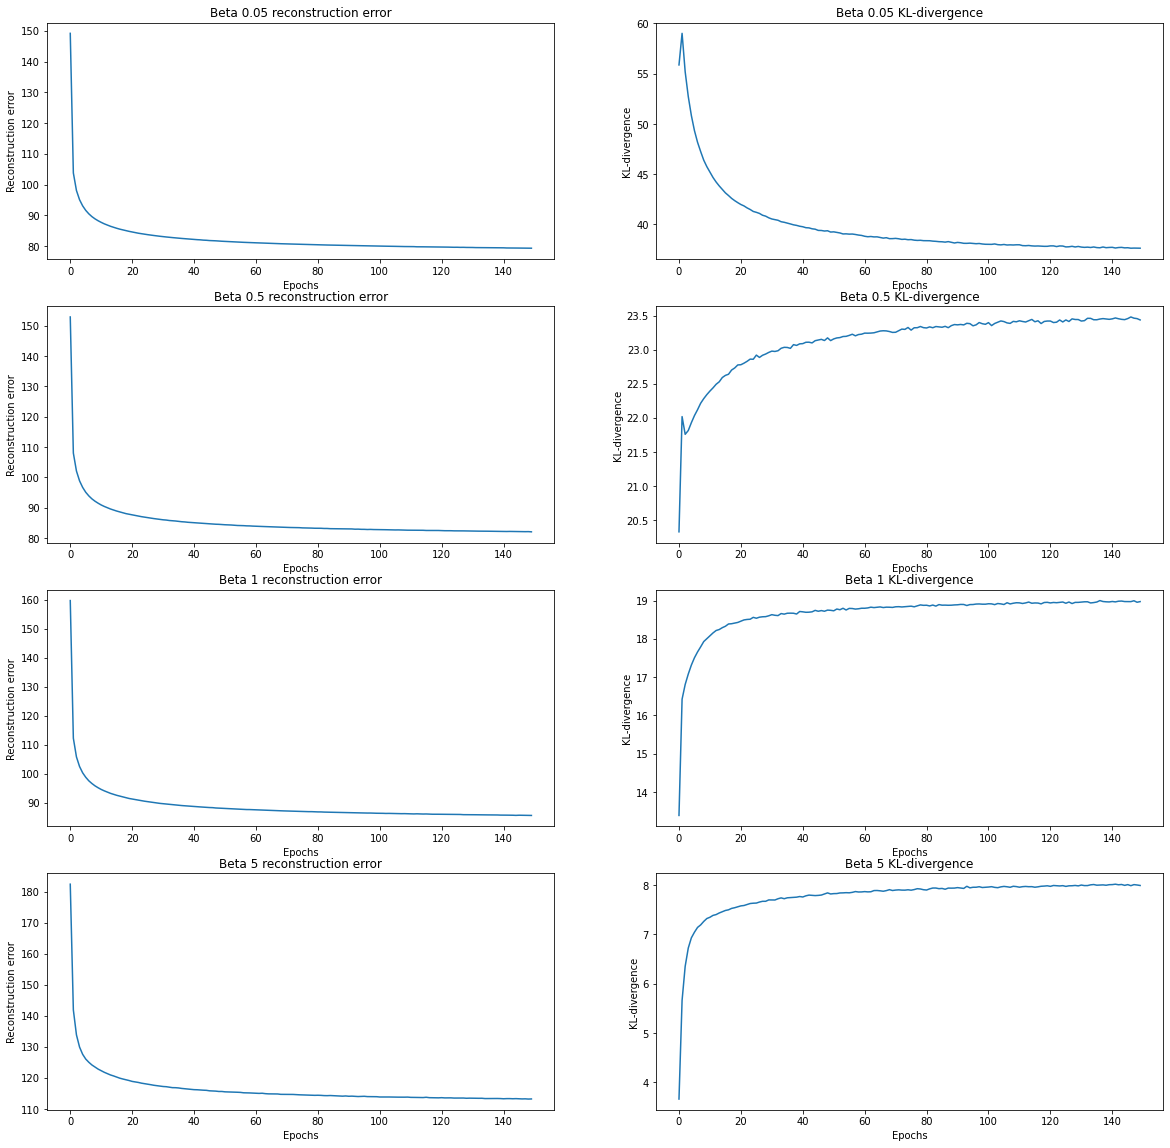

In [8]:
# 4
fig = plt.figure(figsize=(20,20))

num_of_betas = len(BETA_LIST)
plots_per_row = 2
epochs = range(NUM_EPOCHS)

for row_idx in range(num_of_betas):
    subplot_idx = plots_per_row * row_idx
    ax1 = fig.add_subplot(num_of_betas, plots_per_row, subplot_idx+1)
    ax1.plot(epochs, beta_recon_error_table[row_idx])
    ax1.set_title("Beta {0} reconstruction error".format(BETA_LIST[row_idx]))
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Reconstruction error")
    subplot_idx += 1
    ax2 = fig.add_subplot(num_of_betas, plots_per_row, subplot_idx+1)
    ax2.plot(epochs, beta_kl_table[row_idx])
    ax2.set_title("Beta {0} KL-divergence".format(BETA_LIST[row_idx]))
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("KL-divergence")


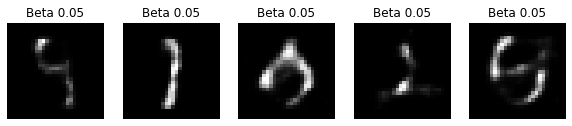

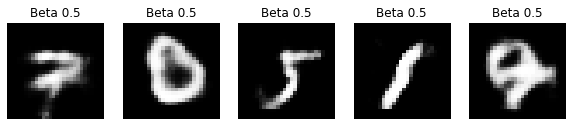

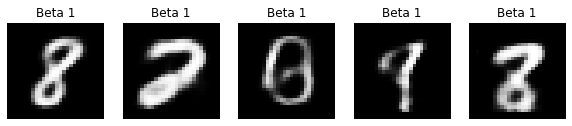

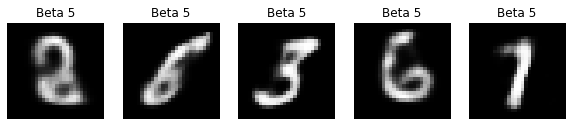

In [9]:
# 5 

for beta_value in BETA_LIST:
  # load data

  fname = "./beta_" + str(beta_value) + "_vae_" + str(NUM_EPOCHS) + "_epochs.pth"
  vae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device).to(device)
  vae.load_state_dict(torch.load(fname))

  # now let's sample from the vae
  n_samples = 5
  vae_samples = vae.sample(num_samples=n_samples).view(n_samples, 28, 28).data.cpu().numpy()
  fig = plt.figure(figsize=(10 ,10))
  for i in range(vae_samples.shape[0]):
      ax = fig.add_subplot(1, 5, i + 1)
      ax.set_title("Beta {0}".format(beta_value))
      ax.imshow(vae_samples[i], cmap='gray')
      ax.set_axis_off()


### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 1 - $\beta$-VAE
---
We will now analyze the results. Answer the following questions:
1. Explain intuitively the loss function of $\beta$-VAE. In your answer, explain the trade-off between the reconstruction loss and the KL-divergence and how it is affected by the $\beta$ parameter. Hint: think about regularization as you learned in the ML course (for example, in linear regression).
2. What is the main trend in the KL and reconstruction loss vs. epochs? In your answer, you should compare between the $\beta$'s.
3. For what values of $\beta$ you would expect better reconstruction (why would we want better reconstruction?) and for what values you would expect higher-quality samples? In your answer, refer to the blurriness in the samples you plotted.
4. Run the cell where you plot the samples (if you separated the cells for each $\beta$, then run all of them) a couple of times (just hit Ctrl + Enter). For which value of $\beta$ there is more *diversity* in the samples? (i.e., if out of 6 samples you get four 9's, it is not diverse).

## <img src="https://img.icons8.com/bubbles/50/000000/information.png" style="height:50px;display:inline"> Answers - Q1
---
### Q1 - section 1
The $\beta$ controls the KL divergence cost (As we want it as low as possible) relative to the reconstruction cost part in the total loss.  
It's similar in a way to the regularization $\lambda$ parameter on weights sum in linear regression (to avoid overfitting due to many degrees of freedom and complexity of the model with big amount of wieghts).  
In VAE we also don't want to let the learned model and learned distribution to overfit to the data given. We want the VAE to be more generalized by applying a diagonal covariance matrix between latent factors/features.  
We strive for low KL divergence in order to have the $q_{\phi}(z|x)$ distribution as close as possible to the isotropic Gaussian ($p(z) \sim \mathcal{N}(0, I)$) for having the desired properties of independence between latent space features/factors (diagonal covariance matrix).
On the other hand, we wish to have as low as possible reconstruction error. 
Meaning, to reproduce as accurate as possible the reconstructed data.  
This is the basic trade off between low and high $\beta$.  
High value of $\beta$ gives a more substantial weight to the $D_{KL}$ and thus the latent space is more as wish it to be (independent factors and more accurately distributed randomly), the reconstruction error on the other hand doesn't get low as we wish it be.  
Low value of $\beta$ gives a more substantial weight to the reconstruction error, thus the reconstruction part (decoder) is more accurate but the $D_{KL}$ remains high and our goal on the latent space distribution is not as we wish it would be.  
If we analize this mathematically more elaborately, we can see that for each sample of $X_1$ (on different ephocs) we get several sampled $Z_1=\{z_{11},z_{12},..\}$. Minimizing the reconstruction error pushes the $z$ latent space variance towards the mean $\mu(X_1)$ with minimum variance ($\Sigma(X_1)=0$) if we had a single $z_1$ from a single epoch the VAE would have behaved as a deterministic AE and will output the mean of each class).The mean $\mu(X_1)$ of each class however is better for reconstruction, as we learn the best reconstructed $\hat{X}$. The problem is that by minimizing the variance, we're at risk of overfitting.
The $D_{KL}$ on the otherhand, tries to push the variance towards the $\Sigma(X_1)=I$ as it tries to be closer to the our wanted distribution. This is more desireable as we want latent space to have some specific distribution with uncorrelated features at the latent space. The mean $\mu(X)$ is pushed towards 0 for all classes and reconstruction will be less accurate per class.  
The $D_{KL}$ therefore adds bias on the reconstruction but that might be a good thing at some extent as we avoid overfitting. This is why, the $\beta$ hyperparameter can be considered as regularization parameter as it controls the classical variance/bias trade off.

We can see from the plots that when the $\beta$ is too low $(0.05)$, the $D_{KL}$ is not playing a siginficant part in the loss and even gets lower a bit (probably, if it had a siginficance, it would have converged to a higher value due to the trade off with the reconstruction error). the $D_{KL}$ start high and remains that way (above 35).  
On high $\beta$ values, we can see from the plots that the $D_{KL}$ has significance that increases the reconstruction error converged values.  
Also, the $D_{KL}$ converged value is lower as the $\beta$ high value doesn't let it get too big.

### Q1 - section 2

On low $\beta=0.05$ we can notice that the model is focused on the reconstruction error loss as it will reduce the loss siginficantly compared to $D_{KL}$. The $D_{KL}$ starts high and at some point the model reduces it moderatly as if finds it can be reduced a bit, but it's not the main trend of the training vs ephocs. The reconstruction error is the siginificant component to reduce.  
As $\beta$ gets higher, the reconstruction error component is less significant vs $D_{KL}$ and we can see the reconstruction error converges to a lower value. The $D_{KL}$ starts with much lower values (compared to low $\beta$ runs) as the training tries to keep $D_{KL}$ low as possible. However, we still see that the training finds more loss reduction on reconstruction error loss and $D_{KL}$ moderately converges to slightly higher value (but still much lower than $D_{KL}$ with lower $\beta s$). 

### Q1 - section 3

We would expect better reconstruction error on lower $\beta$ as the model will focus on it instead of on the $D_{KL}$ loss. The reconstruction is important for compress and decompress from latent space as good as possible, however, this doesn't guarantee a better visualization as the model may overfit deterministically to some means of the data classes with no variance and would not generalize well to real samples of $z$. This may cause blurriness on too low $\beta $ values.
We expect better generalization and less overfiting when we increase the $D_{KL}$ factor, thus the variance is maintained on the $z$ latent space and also its features are more uncorrelated for better encoding of the data.  
We can see that the images gets better as $\beta$ gets higher as the varinace is maintained even though the reconstruction error loss is not drastically minimized.

### Q1 - section 4

We can see better diversity for higher $\beta$ values as the covariance matrix ot the latent space is more similar to a diagonal matrix, thus the factors encoded are more uncorrelated and the decoder trained over it will create more diversity compared to big $D_{KL}$ values in which the latent space distribution might incline to some specific feature and thus will be less diverse in creation of new $X$ from some random sampled $z$.


### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 2 - Conditional VAE (CVAE)
---
Conditional Variational Autoencoder (CVAE) is an extension of Variational Autoencoder (VAE).
However, as you may have noticed, we have no control on the data generation process on VAE. That is, for example, on MNIST, we could not control the latent space, and when we sampled, we would not know what digit would be generated. This could be problematic if we want to generate some specific data. As an example, suppose we want to convert a unicode character to handwriting. In vanilla VAE, there is no way to generate the handwriting based on the character that the user inputted. Concretely, suppose the user inputted character ‘2’, how do we generate handwriting image that is a character ‘2’? We couldn’t.

Hence, CVAE was developed. Whereas VAE essentially models latent variables and data directly, CVAE models lantent variables and data, both conditioned to some random variables.
Recall, on VAE, the objective is:
$$\log P(X) -  D_{KL}[Q(z|X) || P(z|X)]  =  \mathbb{E}_{Q(z|X)}[\log P(X|z)] -D_{KL}[Q(z|X)|| P(z)]  $$
that is, we want to optimize the log likelihood of our data $P(X)$ under some “encoding” error. The original VAE model has two parts: the encoder $Q(x|Z)$ and the decoder $P(X|z)$.

If we focus on the encoder, it models the latent variable $z$ directly based on $X$, and it doesn't care about the different types of $X$ (e.g., it doesn't care if it is 1 or an 8). But wait, this was all the idea of **unsupervised learning**, we have no access to labels. Well, in this case, we have some information (thus, CVAE is sometimes referred to as **semi-supervised** learning model).

Similarly, in the decoder part, it only models $X$ directly based on the latent variable $z$. So, how do we tell the VAE what we want to generate? We can condition encoder and decoder to another things, let's denote them with $c$ (for "condition").

* The encoder is now conditioned on 2 variables- $X, c$: $Q(z|X,c)$ and the decoder in now conditioned on- $z$, $c$: $P(X|z,c)$
* Hence, our variational lower bound objective is now in this following form: $$ \log P(X|c) -  D_{KL}[Q(z|X,c) || P(z|X,c)]  =  \mathbb{E}_{Q(z|X,c)}[\log P(X|z,c)] -D_{KL}[Q(z|X,c)|| P(z|c)] $$ (we just conditioned all of the distributions with a variable $c$)
* So what is different? Almost nothing! We still model $P(z|c) \sim \mathcal{N}(0,I)$, and the rest are modeled by the neural network.
* But how is it done in practice? Simple! **Concatenation**: instead of encoding $X$, we encoded $[X,c]$, that is, we concatenate them. Same for the decoder: we take the latent variable $z$ and concatenate with $c$ and then the input of the decoder is $[z,c]$.
* In PyTorch, we concatenate with `x = torch.cat([x, x_cond], dim=1)` (the 0 dimension is the batch dimension).

The tasks:
* Load the Fashion-MNIST dataset, as in the tuorial, and create a train loader. Note that you get both the images and their **labels**.
* The labels are the classes (0-9). In order to use them in the network we need to convert them to one-hot vectors (0 -> [1,0,0,0,0,0,0,0,0,0], 1 -> [0,1,0,0,0,0,0,0,0,0] ...). The length of the one hot vector in as the number of classes. You are given a function that converts ints to one-hot vectors, use it on the labels, before you perform the concatenation.
* Modify the VAE architecture to support conditionals.
    * Copy-paste the skeleton (the original VAE, from the begining of the tutorial), and just modify the current functions. Note that there **are very few** changes needed.
    * Here are some tips, but feel free to implement as you wish, as long as it works:
        * In Python, you can let a function input be `None`, and then if the user inputs something that is not `None`, the function would act different. Here is an example: `def encode(x, x_cond=None): if x_cond is not None: ...`
        * Here are the parts that we recommend you change:
            * In the Vae module:
                * `def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu"), cond_dim=None)`
                * `def sample(self, num_samples=1, x_cond=None)`
                * `def forward(self, x, x_cond=None)`
            * Note that these are the minimal changes that can be done to implement VAE that supports CVAE. No need to modify VaeEncoder and VaeDecoder when we are using fully-connected layers. However, if we were to use convolutional layers, we would have to change also the encoder and decoder since convolutional layers work on images, and only after the images features from the convolutional layers have been extracted, we would concatenate the the condional $c$ (just before the fully-connected layers that output $\mu, \sigma$.
* Train CVAE on the Fashion-MNIST dataset (100 epochs, at least). Use $\beta$-VAE loss function (it shouldn't have changed from the regular VAE. Save a checkpoint of the network in the format: `fmnist_beta_(value of beta)_cvae_(number of epochs)_epochs.pth`. The rest of the hyper-parameters are up to you.
* Plot $n_{samples}=6$ from the CVAE for 6 classes of your choosing.
* **Tip**: this may take a while, so if everything seems to work, let it run on Google Colab and go grab another coffee.

In [10]:
def labels_to_one_hots(batch, num_classes=10):
  """
  Converts batch of integes numbers to one-hot vector given the vector length
  :param batch: batch of values to convert
  :param num_classes: length of the vector
  :return: one_hot_batch
  """
  one_hot_batch = torch.zeros(batch.size(0), num_classes).to(batch.device)
  for i in range(batch.size(0)):
      one_hot_batch[i, int(batch[i].data.cpu().item())] = 1
  return one_hot_batch

In [11]:
# your code here - you can use as many cells as you need



class Vae(torch.nn.Module):
  def __init__(self, x_dim=28*28, z_dim=10, hidden_size=256, device=torch.device("cpu"), cond_dim=None):
    super(Vae, self).__init__()
    self.device = device
    self.cond_dim = cond_dim
    self.x_dim = x_dim
    self.cat_x_dim = x_dim
    self.z_dim = z_dim
    self.cat_z_dim = z_dim
    if self.cond_dim is not None:
      self.cat_x_dim += self.cond_dim
      self.cat_z_dim += self.cond_dim

    self.encoder = VaeEncoder(x_dim=self.cat_x_dim, hidden_size=hidden_size, z_dim=self.cat_z_dim, device=device)
    self.decoder = VaeDecoder(x_dim=x_dim, hidden_size=hidden_size, z_dim=self.cat_z_dim)

  def encode(self, x):
    z, mu, logvar = self.encoder(x)
    return z, mu, logvar

  def decode(self, z):
    x = self.decoder(z)
    return x

  def sample(self, num_samples=1, x_cond=None):
    """
    This functions generates new data by sampling random variables and decoding them.
    Vae.sample() actually generatess new data!
    Sample z ~ N(0,1)
    """
    z = torch.randn(num_samples, self.z_dim).to(self.device)
    if (self.cond_dim is not None) and (x_cond is not None):
      z = torch.cat([z, labels_to_one_hots(x_cond)], dim=1)
    return self.decode(z)

  def forward(self, x, x_cond=None):
    """
    This is the function called when doing the forward pass:
    return x_recon, mu, logvar, z = Vae(X)
    """
    if x_cond is not None:
      x = torch.cat([x, labels_to_one_hots(x_cond)], dim=1)
    z, mu, logvar = self.encode(x)
    x_recon = self.decode(z)
    return x_recon, mu, logvar, z



In [38]:
# training

# define hyper-parameters
BATCH_SIZE = 128  # usually 32/64/128/256
LEARNING_RATE = 1e-3  # for the gradient optimizer
NUM_EPOCHS = 250  # how many epochs to run?
HIDDEN_SIZE = 256  # size of the hidden layers in the networks
X_DIM = 28 * 28  # size of the input dimension
Z_DIM = 10  # size of the latent dimension
COND_DIM = 10
BETA_VALUE = 1

# Fashion-MNIST
fmnist_train_dataset = torchvision.datasets.FashionMNIST(root='./datasets/',
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

dataloader = DataLoader(fmnist_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# check if there is gpu avilable, if there is, use it
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("running calculations on: ", device)

# here we go

# create our model and send it to the device (cpu/gpu)
cvae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device, cond_dim=COND_DIM).to(device)

# optimizer 
cvae_optim = torch.optim.Adam(params=cvae.parameters(), lr=LEARNING_RATE)

# save the losses from each epoch, we might want to plot it later
epoch_train_loss_list = []

for epoch in range(NUM_EPOCHS):

  epoch_start_time = time.time()
  
  batch_losses = []

  for batch_i, (images, labels) in enumerate(dataloader):
    
    # forward pass
    x = images.to(device).view(-1, X_DIM)  # just the images
    labels = labels.to(device)
    x_recon, mu, logvar, z = cvae(x, labels)
    
    # calculate the loss
    recon_error, kl, loss = beta_loss_function(x_recon, x, mu, logvar, loss_type='bce', beta=BETA_VALUE)

    # optimization (same 3 steps everytime)
    cvae_optim.zero_grad()
    loss.backward()
    cvae_optim.step()
    
    # save loss
    batch_losses.append(loss.data.cpu().item())

  epoch_train_loss_list.append(np.mean(batch_losses))

  if epoch % 5 == 0:
    print("epoch: {} training loss: {:.5f} epoch time: {:.3f} sec".format(epoch, epoch_train_loss_list[-1],
                                                                            time.time() - epoch_start_time))

# saving our model (so we don't have to train it again...)
# this is one of the greatest things in pytorch - saving and loading models
# save
fname = "./fmnist_beta_" + str(BETA_VALUE) + "_cvae_" + str(NUM_EPOCHS) + "_epochs.pth"
torch.save(cvae.state_dict(), fname)
print("saved checkpoint @", fname)

running calculations on:  cuda:0
epoch: 0 training loss: 290.89843 epoch time: 9.190 sec
epoch: 5 training loss: 246.15031 epoch time: 9.070 sec
epoch: 10 training loss: 243.27111 epoch time: 9.150 sec
epoch: 15 training loss: 241.97542 epoch time: 9.026 sec
epoch: 20 training loss: 241.27049 epoch time: 8.971 sec
epoch: 25 training loss: 240.79536 epoch time: 8.948 sec
epoch: 30 training loss: 240.45066 epoch time: 8.798 sec
epoch: 35 training loss: 240.16908 epoch time: 8.839 sec
epoch: 40 training loss: 239.91740 epoch time: 8.819 sec
epoch: 45 training loss: 239.72755 epoch time: 8.699 sec
epoch: 50 training loss: 239.55627 epoch time: 8.841 sec
epoch: 55 training loss: 239.39426 epoch time: 8.833 sec
epoch: 60 training loss: 239.30980 epoch time: 8.710 sec
epoch: 65 training loss: 239.17238 epoch time: 8.765 sec
epoch: 70 training loss: 239.07702 epoch time: 8.693 sec
epoch: 75 training loss: 238.99085 epoch time: 8.782 sec
epoch: 80 training loss: 238.90358 epoch time: 8.630 sec


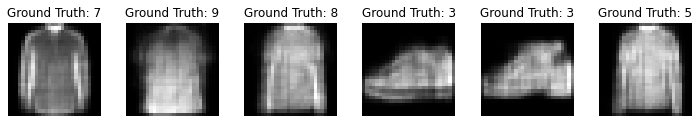

In [49]:
fname = "./fmnist_beta_" + str(BETA_VALUE) + "_cvae_" + str(NUM_EPOCHS) + "_epochs.pth"
cvae = Vae(x_dim=X_DIM, z_dim=Z_DIM, hidden_size=HIDDEN_SIZE, device=device, cond_dim=COND_DIM).to(device)
cvae.load_state_dict(torch.load(fname))
n_samples = 6
x_cond = torch.randint(low=0,high=10,size=(n_samples,)).to(device)
vae_samples = cvae.sample(num_samples=n_samples, x_cond=x_cond).view(n_samples, 28, 28).data.cpu().numpy()

fig = plt.figure(figsize=(10 ,10))
for i in range(n_samples):
  ax = fig.add_subplot(1,n_samples,i+1)
  ax.imshow(vae_samples[i], cmap='gray', interpolation='none')
  ax.set_title("Ground Truth: {}".format(x_cond[i]))
  ax.set_axis_off()
plt.tight_layout()


### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 2 - Conditional VAE
---
1. Can we perform interpolation of the latent space as we did in the tutorial? What is the meaning of doing **in-class** interpolation in the case of Fashion-MNIST? Explain.
2. Why did we convert the the classes number to one-hot vectors? Think of the other inputs to the networks and the values that the neurons accept. What is the risk of using just one number as the condition instead of a vector?
3. How is the quality of the samples? How can the quality be improved? In you answer, refer to the bluriness in the samples.

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 2 - BONUS - Pokemon: Gotta Generate 'Em All!
---
This is a **non-mandatory**, more challenging task. Come back here only if you are done with the rest of the exercise and want to take on a challenge.

* Note - you should pick one of the following:
    * Fully-connected - work with grayscale images (5 points)
    * Convolutional - work with RGB images (10 points)
* No matter what type of model you chose, you need to answer the bonus questions that follow the code.

In this task we are going to (try) generate new pokemons! Our dataset includes ~900 pokemons. Each sample is a 60x60 image and the type of the pokemon (18 classes). The type is already in one-hot form. If you have access to a GPU, we recommend trying the convolutional version of this task.

Let's look at the data, for the **fully-connected** version.

In [ ]:
from pokemon_dataset import PokemonDataset
poke_data = PokemonDataset(root='./data/pokemon', rgb=False)
sample_dataloader = DataLoader(poke_data, batch_size=6, shuffle=True, drop_last=True)

In [ ]:
fig = plt.figure(figsize=(10 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i][0].data.cpu().numpy(), cmap="gray")
    ax.set_axis_off()
    
print("can you name these pokemons?")

In [ ]:
# let's look at the types encoding
poke_data.type_to_one_hot

**The task**: Implement CVAE for the pokemon dataset, it should not be different than the one you implemented for Fashion-MNIST. The task is to define the model and tune the hyper-parameters. 
Note that due to being a really small dataset (only 900 examples!) you will need a really large number of epochs to get something. We don't expect to see actual pokemons, but we want to see the that the networks learned something. You will also need a larger latent space dimension, as pokemons are more complex than cloths.

* If you have taken the **Computer Vision** course - you should add **data augementations** to the images, to create a more diverse dataset. Recommended augmentations: `RandomHorizontalFlip`, `ColorJitter`, random horizontal translation (up to 5 pixels).



* Train CVAE on the pokemon dataset. Save a checkpoint once you are done: `pokemon_beta_(value of beta)_vae_(num epochs)_epochs.pth`.
* Plot samples for at least 6 types of your choosing (try to find the better ones).
* Plot reconstructions for at least 6 types of your choosing.

In [ ]:
# your code here - you can use as many cells as you need

### Have access to a GPU and feel adventurous (CNN version)?
* If you have completed the fully-connected verion, you can just skip to the bonus questions.

If you feel creative and want to work with CNNs, we are giving you the VaeCnnEncoder and VaeCnnDecoder architectures, and all you have to do is implement the Vae class using these, and run the VAE with RGB images.
Let's look at the data.

In [ ]:
from pokemon_dataset import PokemonDataset
poke_data = PokemonDataset(root='./data/pokemon', rgb=True)
sample_dataloader = DataLoader(poke_data, batch_size=6, shuffle=True, drop_last=True)

fig = plt.figure(figsize=(10 ,5))
samples, labels = next(iter(sample_dataloader))
for i in range(samples.size(0)):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.imshow(samples[i].permute(1, 2, 0).data.cpu().numpy())  # permute to (Height, Width, Channels)
    ax.set_axis_off()
    
print("can you name these pokemons?")

### Your Turn
* Impelement the convolutional CVAE and train it. Save a checkpoint `"pokemon_cnn_beta_(value of beta)_vae_(num epochs)_epochs.pth"`
* Plot samples for at least 6 types of your choosing (try to find the better ones).
* Plot reconstructions for at least 6 types of your choosing.


* Note that the call to the loss function in the training loop is in the form: `loss = loss_function(x_recon, x.permute(0, 2, 3, 1), mu, logvar, loss_type='bce', beta=beta)`.
    * This is because `x_recon` is in the shape (batch_size, H, W, C) and `x` is (batch_size, C, H, W).
* Use a lower leraning rate (start with `1e-4`).

* Components:
    * Conv2D - `nn.Conv2d(in_channels, out_channels, kernel_size, stride)`
    * Deconv2d - `nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)`
    * Batch Normalization 1D - `nn.BatchNorm1d(num_features, affine=True)`
    * Batch Normalization 2D - `nn.BatchNorm2d(num_features, affine=True)`
    * Calculate the convolutional output size with `_get_conv_out(self, shape)` as in tutorial 8.
    * FC/Linear - `nn.Linear(in, out)`

#### Encoder Architecture - `VaeCnnEncoder(torch.nn.Module)`
* Block 1:
    * Conv2d - `in_channels=3, out_channels=128, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - 128 features
    * ReLU (or any other activation you want)
* Block 2:
    * Conv2d - `in_channels=128, out_channels=64*4, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - $64*4$ features
    * ReLU (or any other activation you want)
* Block 3:
    * Conv2d - `in_channels=64*4, out_channels=64*8, kernel_size=(3, 3), stride=(2, 2), padding=1`
    * Batch Normalization 2D - $64*8$ features
    * ReLU (or any other activation you want)
* FC1 ($\mu$) - `nn.Linear(self._get_conv_out(x_shape) + self.cond_dim, self.z_dim)`
* FC1 ($\Sigma$) - `nn.Linear(self._get_conv_out(x_shape) + self.cond_dim, self.z_dim)`

#### Decoder Architecture - `VaeCnnDecoder(torch.nn.Module)`
* FC1 ($z$) - `nn.Linear(self.z_dim (+cond_dim), 64 * 4 * 4 * 4)`
* Batch Normalization 1D - $64*4*4*4$ features.
* Block 1:
    * Deconv2d - `in_channels=64 * 4, 64 * 2, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
    * Batch Normalization 2D - 128 features
    * ReLU (or any other activation you want)
* Block 2:
    * Deconv2d - `in_channels=128, 64, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
    * Batch Normalization 2D - 64 features
    * ReLU (or any other activation you want)
* Block 3:
    * Deconv2d - `in_channels=64, 64, kernel_size=(3, 3), stride=(2, 2), padding=2, output_padding=1`
    * Batch Normalization 2D - 64 features
    * ReLU (or any other activation you want)
* Deconv2d - `in_channels=64, 3, kernel_size=(3, 3), stride=(2, 2), padding=1, output_padding=1`
* Sigmoid



In [ ]:
# your code here - you can use as many cells as you need

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Bonus Question
---
1. What do you think about the results on the Pokemon dataset? Name at least 2 reasons for the VAE somewhat low performance on the Pokemon dataest.
2. Suggest ideas to improve the performance (at least 2).

### <img src="https://img.icons8.com/cotton/64/000000/grand-master-key.png" style="height:50px;display:inline"> Part 2 - Spectral Clustering - Prologue
---
In this task we are going to explore Spectral Clustering for image segmentation. 
In computer vision, **image segmentation** is the process of partitioning a digital image into multiple segments (sets of pixels, also known as image objects). The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze. Image segmentation is typically used to locate objects and boundaries (lines, curves, etc.) in images. More precisely, image segmentation is the process of assigning a label to every pixel in an image such that pixels with the same label share certain characteristics.

We are going tor compare K-Means to Spectral Clustering, and as you recall, K-Means is also a step in the the spectral clustering algorithm (remember where?).

In [ ]:
# imports for the exrcise - part 2
# you can add more if you wish (but it is not really needed)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings

# sklearn imports
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering, KMeans

warnings.filterwarnings(category=UserWarning, action="ignore")

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 3 - Spectral Clustering Demonstration
---
Run the next code cell and answer (below the code cell) the following questions:
1. Run the cell 3 times (Ctrl + Enter). Why are the results different in each run?
2. The `image_to_graph` function builds a graph from the image. Explain how the graph is built (you can read the documentation of this function with `help(image.img_to_graph)`. What are the weights of edges?
3. Explain the code commands in lines (press Esc + L to view line numbers): 9, 12

total time: 5.553 sec


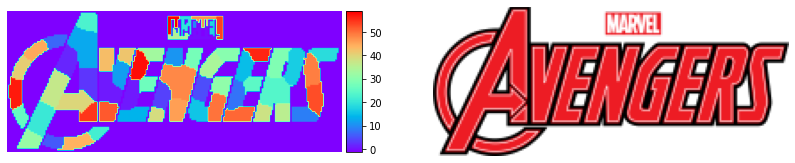

In [ ]:
# run this cell
start_time = time.time()
original_img = Image.open("./data/a_logo_s.png")
grayscale_image = original_img.convert("L")  # convert to grayscale
img = np.array(grayscale_image)  # convert to np.array
img[img==255] = 0  # zero-out the background, we don't care about it
mask = img.astype(np.bool)  # create a mask for the graph-building function
img = img.astype(float) / 255  # convert to numbers in [0,1]
img += 1 / 255 + (0.2 / 255) * np.random.randn(*img.shape)  # add random noise

graph = image.img_to_graph(img, mask=mask)  # build a graph with the gradients as weights
graph.data = np.exp(-graph.data / graph.data.std())  # convert gradients to affinity

labels = spectral_clustering(graph, n_clusters=60, eigen_solver='arpack')  # run spectral clustering
label_im = np.full(mask.shape, -1.0)  # labels -> image
label_im[mask] = labels  # assign correct labels

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(121)
imsh = ax1.imshow(label_im, cmap=plt.cm.rainbow)
ax1.set_axis_off()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(imsh, cax=cax)
ax2 = fig.add_subplot(122)
ax2.imshow(np.array(original_img))
ax2.set_axis_off()
print("total time: {:.3f} sec".format(time.time() - start_time))

### <img src="https://img.icons8.com/color/48/000000/code.png" style="height:50px;display:inline"> Task 3 - Image Segmentation with Spectral Clustering & K-Means
---
1. Run K-Means on `a_logo_s.png`. Tune the number of clusters and number of iterations and plot the results in the same way as in the demonstration.
    * In order to use K-means on images, you need to reshape it: `img.reshape(-1,1)`
    * To run K-Means: create an instance of K-Means: `k_means = KMeans(n_clusters=, max_iter=)` and *fit* the reshaped img: `k_means.fit(...)`
    * To access the labels (=the assignment) of each pixel, call `labels = k_means.labels_`
2. Load `iron_man_p_s.png` and run K-Means and Spectral Clustering. Tune each algorithm's hyper-parameters. Plot the results.

In [ ]:
# your code here - you can use as many cells as you need

### <img src="https://img.icons8.com/bubbles/48/000000/ask-question.png" style="height:50px;display:inline"> Question 4 - Image Segmentation with Spectral Clustering & K-Means
---
1. Compare the results of K-Means and Spectral Clustering on the Avengers logo. Which algoirthm yields more satisfying results, in your opinion? Explain.
2. Compare the results of K-Means and Spectral Clustering on Iron Man. Explain how did you tune the parameters (i.e., how did you pick the number of clusters). What is the difference between the Avengers logo and Iron Man?
3. Summarize the advantages and disadvantages of K-Means and Spectral Clustering for image segmentation (running time, type of images, amount of tuning...)

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
* Datasets from <a href="https://www.kaggle.com/">Kaggle</a> - https://www.kaggle.com/